## Using three-year average for wet/dry/average year per Peter's suggestion

In [1]:

import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal
import importlib
import h5py
sys.path.append('/Users/ajc/Core/PyScript')
import readdata

In [334]:
path = "/Users/ajc/Core/simulations/barrow_watershed"
outfile ='/Users/ajc/Core/PostProcessing/barrow_watershed/2021/September/set_4_3yr_avg/'

In [3]:
colors = ['r','blue','grey','green','darkgreen','k']
marks = ['.','*', '+', 'o']
marks = ['-','-','-','-','-']

SimLabels = ['S%s'%i for i in range(3,0,-1)]

In [346]:
#Set 1 : flow processes
S1 = [os.path.join(path, 'CESM_04/CESM_5050_R1%s_B'%i) for i in range(3)]
S3 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R3%s'%i) for i in range(1)] 
S5 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s'%i) for i in range(1)]
Simulations = [S5, S3, S1]
Labels = ['dynamic-microtopography','static-microtopography','no-microtopography']
#Labels = ['Realistic', '', 'Simplified']
#Labels = ['Realistic', '', 'Simplistic']

In [ ]:
# Set 2: ice rich top porosity sensitivity 
S5_P80 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s'%i) for i in range(1)]
S5_P70 = [os.path.join(path, 'CESM_05/CESM_I5050_P70_R5%s'%i) for i in range(1)]
S5_P90 = [os.path.join(path, 'CESM_05/CESM_I5050_P90_R5%s'%i) for i in range(1)]
Simulations = [S5_P80, S5_P70, S5_P90]
Labels = ['dynamic-microtopography (por = 80%)','dynamic-microtopography (por = 70%)','dynamic-microtopography (por = 90%)']

In [ ]:
# Set 2: ice rich top porosity sensitivity
S5_D0515 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s'%i) for i in range(1)]
S5_D0020 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s_D0020'%i) for i in range(1)]
S5_D1010 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s_D1010'%i) for i in range(1)]
S5_D2020 = [os.path.join(path, 'CESM_05/CESM_I5050_P80_R5%s_D2020'%i) for i in range(1)]
Simulations = [S5_D0515, S5_D0020, S5_D1010,S5_D2020]
Labels = ['dynamic-microtopography (d = [5,15])','dynamic-microtopography (d = [0,2])',
          'dynamic-microtopography (d = [10,10])', 'dynamic-microtopography (d = [20,20])']



In [5]:
sim_len = len(Simulations)
sim_len

3

In [6]:
#path_sf ="/Users/ajc/Core/simulations/projections/barrow_watershed_02/CESM_15/CESM_5050_R60_B/visdump_surface_star_data.h5"
#file_surf= h5py.File(path_sf,'r')
#surface_area = np.sum(list(file_surf['surface_star-cell_volume.cell.0']['100095']))
surface_area = 112635.47903126487
print (surface_area)
molar_density = 55500.

112635.47903126487


In [7]:
def read_file(file):
    d = np.loadtxt(file,usecols=1,skiprows=6)
    t1 = np.loadtxt(file,usecols=0,skiprows=6)
    t = np.array([x/86400./365. for x in t1])
    #print (len(d),len(t))
    l = np.minimum(len(d),len(t))
    return d[:l],t[:l]

def read_set(set,var='surface_flux-halfday.dat'):
    dat = []
    tim = []
    for s in set:
        file = os.path.join(path,s, var)
        #print (file)
        d = np.loadtxt(file,usecols=1,skiprows=6)
        t1 = np.loadtxt(file,usecols=0,skiprows=6)
        t = np.array([x/86400./365. for x in t1])
        
        L = len(d)%(365*2)
        if L >0:
            d = d[:-L]
            t = t[:len(d)]
            
        dat.append(d)
        tim.append(t)
    dat = np.concatenate(dat)
    tim = np.concatenate(tim)
    
    return dat, tim


In [8]:
def get_vars_names(simul):
    names = dict()
    #file = os.path.join(Simulations[0][0],'data_collection.dat')
    file = os.path.join(simul,'data_collection.dat')
    with open(file) as fd:
        count = 0
        for f in fd:
            if ('Observation Name' in f):
                f1 = f.split(':')
                #print (f1, f[-1])
                if 'time [d]' in f1[-1]:
                    names['Time'] = count
                    #print (f1, f1[-1],names)
                elif 'outlet discharge [mol d^-1]' in f1[-1]:
                    names['Discharge'] = count 
                elif 'total evaporation [m d^-1]' in f1[-1]:
                    names['ET'] = count
                elif 'snow precipitation [m d^-1]' in f1[-1]:
                    names['Psnow'] = count
                elif 'rain precipitation [m d^-1]' in f1[-1]:
                    names['Prain'] = count
                elif 'subsurface water content [mol]' in f1[-1]:
                    names['SS_wc'] = count
                    #print (count)
                elif 'surface water content [mol]' in f1[-1]:
                    #print (count)
                    names['Sf_wc'] = count
                elif 'snow water content [mol]' in f1[-1]: #but this is in m^3 correction
                    names['Snow_wc'] = count
                elif 'surface air temperature [K]' in f1[-1]:
                    names['Tair'] = count
                elif 'surface carbon decomposition rate [-]' in f1[-1]:
                    names['Sf_CDR'] = count
                elif 'surface moisture content [-]' in f1[-1]:
                    names['Sf_mc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface volumetric wc [-]' in f1[-1]:
                    names['Sf_vol_wc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface column average temperature [K]' in f1[-1]:
                    names['Sf_avg_T'] = count
                elif 'surface ALT average temperature [K]' in f1[-1]:
                    names['Sf_ALT_avg_T'] = count
                elif 'surface saturated_fraction [-]' in f1[-1]:
                    names['Sf_sat_frac'] = count
                elif 'surface thaw depth min [m]' in f1[-1]:
                    names['Sf_TD_min'] = count
                elif 'surface thaw depth max [m]' in f1[-1]:
                    names['Sf_TD_max'] = count
                elif 'surface maximum thaw depth [m]' in f1[-1]:
                    names['Sf_maxTD'] = count
                elif 'surface water table [m]' in f1[-1]:
                    names['Sf_WT'] = count
                elif 'surface subsurface exchange [m]' in f1[-1]:
                    names['Sf_exchangeFlux'] = count
                elif 'surface initial elevation [m]' in f1[-1]:
                    names['Sf_InitElev'] = count
                elif 'surface mean subsidence [m]' in f1[-1]:
                    names['Sf_mean_Subsidence'] = count
                else:
                    #names['Sf_DNE_%s'%count] = count
                    print ('DNE:',count, f[-1])
                count = count + 1
    return names

In [9]:
forcing_watershed_ET = h5py.File("/Users/ajc/Core/PreProcessing/ats-intermediate-ngee/data/SNAP/CESM-RCP8.5-2006-2100_dm1985-2015-ET_2006.h5",'r')


298.6617268856559 442.80033994070186 (array([1]),) (array([7]),)
Min  136.91912394364385 1 136.91912394364385
Max  442.80033994070186 7 442.80033994070186
Mean  298.6617268856559 23 299.8370056061752


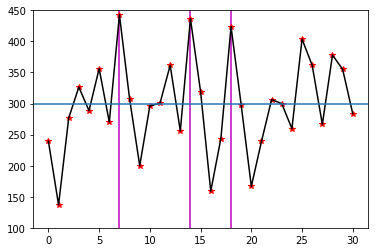

In [156]:
# Fengming data with ET loop
d1 = forcing_watershed_ET['precipitation rain [m s^-1]']
d2 = forcing_watershed_ET['precipitation snow [m SWE s^-1]']
rain_mm = np.reshape(d1,(-1,365)).mean(axis=1)*86400*365*1000
snow_mm = np.reshape(d2,(-1,365)).mean(axis=1)*86400*365*1000
precip_annual = snow_mm + rain_mm
r1 = np.array(d1)*86400*1000
r2 = np.array(d2)*86400*1000
precip_daily = r1 + r2

s= 0
e = s + 31
pmax,pmin,pmean = np.max(precip_annual[s:e]), np.min(precip_annual[s:e]), np.mean(precip_annual[s:e])
print (np.mean(precip_annual[s:e]), np.max(precip_annual[s:e]), np.where(precip_annual[s:e]== pmin), np.where(precip_annual[s:e]== pmax))

print ('Min ', pmin, s+1, precip_annual[1])
print ('Max ', pmax, s+7, precip_annual[7])
print ('Mean ', pmean, s+23, precip_annual[23]) #typical
x3 = np.arange(s,e,1)
plt.plot(x3,precip_annual[s:e],'r*')
plt.plot(precip_annual[:e],'k')
plt.axhline(pmean)
plt.vlines(x=[7,14,18],ymin=0, ymax=500,color='m')
#plt.vlines(x=[1,16,20],ymin=0, ymax=500,color='g')
#plt.vlines(x=[11,19,23],ymin=0, ymax=500,color='c')
plt.ylim(100,450)
typ_yr = [11,19,23]
wet_yr = [7,14,18]
dry_yr = [1,16,20]

In [11]:
print (typ_yr, wet_yr, dry_yr)

[11, 19, 23] [7, 14, 18] [1, 16, 20]


In [12]:
#Read discharge

time = 2006 + np.linspace(0,94,94,dtype='int')
to_day_mm = 86400 * 1000
to_year_mm = 86400 * 365 * 1000
basin_area = 112635.48
to_mm = 1000.

In [13]:
def get_daily_data():
    daily = dict()
    for i,sim in enumerate(Simulations):
        df = pd.DataFrame(columns=[''])
        #df.columns = names.keys()
        
        for s in sim:
            file = os.path.join(s,'data_collection.dat')
            
            df1 = pd.read_csv(file, comment='#')
            names = get_vars_names(s)
            #print (names)
            print (s, len(names.keys()))
            df1.columns = names.keys()
            #print (names.keys())
            rows,cols = df1.shape
            rows = rows - rows%365.
            df1 = df1.truncate(before=0,after=rows-1,axis='index')
            #break
            df = df.append(df1)
            #print (df)
        daily[SimLabels[i]] = df
        
    return daily

SimData_daily = get_daily_data()
print (SimData_daily['S1'].keys())
print (SimData_daily['S2'].keys())
print (SimData_daily['S3'].keys())

/Users/ajc/Core/simulations/barrow_watershed/CESM_05/CESM_I5050_P80_R50 23
/Users/ajc/Core/simulations/barrow_watershed/CESM_05/CESM_I5050_P80_R30 21
/Users/ajc/Core/simulations/barrow_watershed/CESM_04/CESM_5050_R10_B 16
/Users/ajc/Core/simulations/barrow_watershed/CESM_04/CESM_5050_R11_B 16
/Users/ajc/Core/simulations/barrow_watershed/CESM_04/CESM_5050_R12_B 16
Index(['', 'Time', 'Discharge', 'ET', 'Psnow', 'Prain', 'Sf_wc', 'SS_wc',
       'Snow_wc', 'Tair', 'Sf_CDR', 'Sf_mc', 'Sf_gc', 'Sf_vol_wc', 'Sf_avg_T',
       'Sf_ALT_avg_T', 'Sf_sat_frac'],
      dtype='object')
Index(['', 'Time', 'Discharge', 'ET', 'Psnow', 'Prain', 'Sf_wc', 'SS_wc',
       'Snow_wc', 'Tair', 'Sf_CDR', 'Sf_mc', 'Sf_gc', 'Sf_vol_wc', 'Sf_avg_T',
       'Sf_ALT_avg_T', 'Sf_sat_frac', 'Sf_TD_min', 'Sf_TD_max', 'Sf_maxTD',
       'Sf_WT', 'Sf_exchangeFlux'],
      dtype='object')
Index(['', 'Time', 'Discharge', 'ET', 'Psnow', 'Prain', 'Sf_wc', 'SS_wc',
       'Snow_wc', 'Tair', 'Sf_CDR', 'Sf_mc', 'Sf_gc', 'Sf_v

In [14]:
def getSurfaceData():
    Data = []
    var ='surface_star-thaw_depth'
    for i,sim in enumerate(Simulations[2]):

        infile = os.path.join(sim,'ats_vis_surface_star_data.h5')
        dx=h5py.File(infile,'r')
        Dat11 = np.array(readdata.GetSurfVarFromVis_All(infile,var)[var])
        Dat11 = Dat11.max(axis=1)
        a1 = len(Dat11)%365
        a2 = len(Dat11) - a1

        Dat = Dat11[:a2]
        Data.append(Dat)

    #d = dict()
    #d[var] = np.concatenate(Data)
    d = np.concatenate(Data)
    
    return d

In [15]:
SimData_daily['S1']['Sf_TD_max'] = getSurfaceData()

In [16]:
#print (SimData_daily)
to_year = 365
to_mm = 1000
def get_discharge():
    Q_daily = dict()
    Q_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1/(molar_density*surface_area)
        d = [x* convert for x in SimData_daily[keys[i]]['Discharge'] ]
        Q_daily[keys[i]]= d*to_mm
        #print (d.shape)
        Q_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return Q_daily, Q_annual
Q_daily, Q_annual = get_discharge()


def get_time():
    T_daily = dict()
    T_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1./(365)
        d = [1985 + x* convert for x in SimData_daily[keys[i]]['Time'] ]
        T_daily[keys[i]]= d
        T_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)
    return T_daily, T_annual
T_daily, T_annual = get_time()

dict_keys(['S3', 'S2', 'S1']) ['S3', 'S2', 'S1']
dict_keys(['S3', 'S2', 'S1']) ['S3', 'S2', 'S1']


In [17]:
def get_ET():
    ET_daily = dict()
    ET_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    #print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['ET'] ]
        ET_daily[keys[i]]= d*to_mm
        ET_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return ET_daily, ET_annual
ET_daily, ET_annual = get_ET()

In [118]:
def get_saturated_fraction():
    SFrac_daily = dict()
    SFrac_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['Sf_sat_frac'] ]
        SFrac_daily[keys[i]]= d
        SFrac_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)
    return SFrac_daily, SFrac_annual
SFrac_daily, SFrac_annual = get_saturated_fraction()

def get_volumetric_wc():
    SFrac_daily = dict()
    SFrac_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['Sf_vol_wc'] ]
        SFrac_daily[keys[i]]= d
        SFrac_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)
    return SFrac_daily, SFrac_annual
VWC_daily, VWC_annual = get_volumetric_wc()

def get_gas_content():
    GC_daily = dict()
    GC_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['Sf_gc'] ]
        GC_daily[keys[i]]= d
        GC_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)
    return GC_daily, GC_annual
GC_daily, GC_annual = get_gas_content()


def get_ave_TD():
    ATD_daily = dict()
    ATD_annual = dict()
    ATDmin_annual = dict()
    ATDmax_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    
    for i in range(size):
        dmax = np.array([x for x in SimData_daily[keys[i]]['Sf_TD_max'] ])
        
        dd = np.reshape(dmax,(-1,365))#.mean(axis=1)
        dat = []
        for d2 in dd:
            x2 = np.mean(d2[np.nonzero(d2)])
            dat.append(x2)
        ATD_annual[keys[i]] = np.array(dat)

    return ATD_daily, ATD_annual
ATD_daily, ATD_annual = get_ave_TD()

In [38]:
#Max thaw depth per day, then find mean over the summer

In [20]:
def get_Carbon():
    CDR_daily = dict()
    CDR_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    for i in range(size):
        convert = 1#/(molar_density*surface_area)
        d = [x * convert for x in SimData_daily[keys[i]]['Sf_CDR'] ] 
        CDR_daily[keys[i]]= d#*to_mm
        CDR_annual[keys[i]]= np.reshape(d,(-1,365)).sum(axis=1)#*to_year #* to_mm
    return CDR_daily, CDR_annual
CDR_daily, CDR_annual = get_Carbon()


# Typical year

In [349]:
#Typical year
years_typ = [[t for t in typ_yr], [t + 31 for t in typ_yr], [t + 31 * 2 for t in typ_yr]] 

#wet year loop
#cesm_years_wet = [2006+wet_yr, 2006 + wet_yr + 31, 2006 + wet_yr + 31*2]  
years_wet = [[t for t in wet_yr], [t + 31 for t in wet_yr], [t + 31 * 2 for t in wet_yr]] 

years_dry = [[t for t in dry_yr], [t + 31 for t in dry_yr], [t + 31 * 2 for t in dry_yr]] 

Years_o = ['Early', 'Mid', 'Late']
Years = [years_dry, years_typ, years_wet]

In [350]:
print (years_wet, years_wet[2][2]+2006 + 21)

[[7, 14, 18], [38, 45, 49], [69, 76, 80]] 2107


Early
Mid
Late


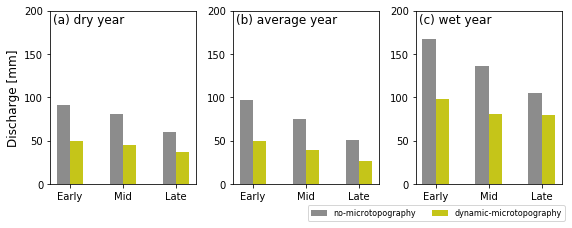

In [351]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['y', 'g', 'grey','grey']

# Discharge
for k in range(3):
    for i1, i in enumerate([2,0]):
        s = SimLabels[i]
        d = []
        for k1 in Years[k]:
            sm = np.mean(Q_annual[s][k1])
            d.append(sm)
            #print (s, k1)
        xx = x - 0.125 + i1*0.25
        axs[k].bar(xx, height=d, width=0.25,color=Colors[i],alpha=0.9,label=Labels[i])


    axs[0].set_ylabel('Discharge [mm]',fontsize=12, fontweight='normal')
    #axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x)
    print (Years_o[k])
    axs[k].set_xticklabels(Years_o)

    axs[k].set_yticks(np.arange(0,200.01,50))
    axs[k].set_ylim(0,200)

plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=2, bbox_to_anchor=(0.95,-0.2, .1, .1))

A = ['(a) dry year','(b) average year', '(c) wet year' ]
loc = [[-0.32,185] for i in [-0.25,137,0.77,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)

plt.savefig(outfile+'/Q_wet_dry_avg_A.pdf', bbox_inches='tight', dpi=500)

# Wet Year

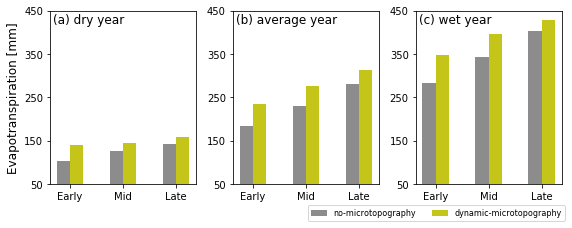

In [353]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['y', 'g', 'grey','grey']
# Discharge
for k in range(3):
    for i1, i in enumerate([2,0]):
        s = SimLabels[i]
        d = []
        for k1 in Years[k]:
            sm = np.mean(ET_annual[s][k1])
            d.append(sm)
            #print (s, k1)
        xx = x - 0.125 + i1*0.25
        axs[k].bar(xx, height=d, width=0.25,color=Colors[i],alpha=0.9,label=Labels[i])

    axs[0].set_ylabel('Evapotranspiration [mm]',fontsize=12, fontweight='normal')
    #axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x)
    axs[k].set_xticklabels(Years_o)

    axs[k].set_yticks(np.arange(50,451,100))
    axs[k].set_ylim(50,450)

plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=2, bbox_to_anchor=(0.95,-0.2, .1, .1))

#plt.tight_layout()
A = ['(a) dry year','(b) average year', '(c) wet year' ]
loc = [[-0.32,420] for i in [-0.25,137,0.77,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)
#plt.tight_layout()
plt.savefig(outfile+'/ET_wet_dry_avg_A.pdf', bbox_inches='tight', dpi=500)

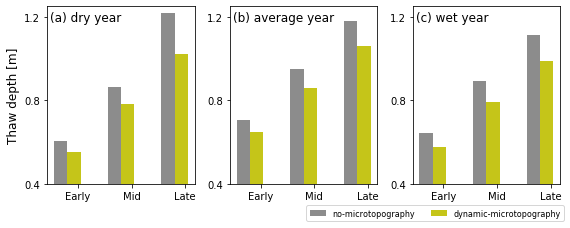

In [354]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['y', 'g', 'grey','grey']

# Discharge
for k in range(3):
    for i1, i in enumerate([2,0]):
        s = SimLabels[i]
        d = []
        #thaw = []
        for k1 in Years[k]:
            sm = np.mean(ATD_annual[s][k1])
            d.append(sm)
            #print (s, k1)
        xx = x - 0.125 + i1*0.25
        axs[k].bar(xx, height=d, width=0.25,color=Colors[i],alpha=0.9,label=Labels[i])

    axs[0].set_ylabel('Thaw depth [m]',fontsize=12, fontweight='normal')
    #axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x+0.2)
    axs[k].set_xticklabels(Years_o)

    axs[k].set_yticks(np.arange(0.4,1.2501,0.4))
    axs[k].set_ylim(0.4,1.25)

plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=2, bbox_to_anchor=(0.95,-0.2, .1, .1))

A = ['(a) dry year','(b) average year', '(c) wet year']
loc = [[-0.32,1.18] for i in [-0.25,137,0.77,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)

plt.savefig(outfile+'/TD_wet_dry_avg_A.pdf', bbox_inches='tight', dpi=500)

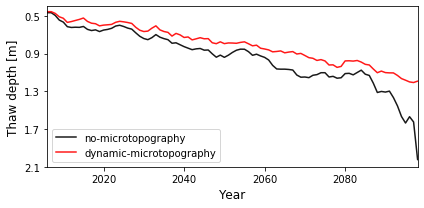

In [385]:
# Thaw depth timeseries
def get_moving_averageA(d, m=5):
    d_avg = []
    len1 = len(d)
    for i in range(len1):
        if i < m:
            s1 = np.mean(d[:i+1])
        else:
            s1= np.mean(d[i-m:i])

        d_avg.append(s1)
    return d_avg

def get_moving_average(d, m=5):
    d_avg = []
    len1 = len(d)
    mid = int(m/2)
    for i in range(len1):
        if i < mid:
            s1 = np.mean(d[:mid])
        elif (i < len1-mid):
            s1= np.mean(d[i-mid:i+mid])
        else:
            #print (i, mid, d[-mid:])
            s1= np.mean(d[-mid:])
        d_avg.append(s1)
    return d_avg

fig, axs = plt.subplots(1,1, figsize=(6,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
#axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['r', 'k', 'k','grey']

# Discharge

for i1, i in enumerate([2,0]):
    s = SimLabels[i]
    d = 0*ATD_annual[s][0] - get_moving_average(ATD_annual[s], 5)
    axs.plot(T_annual[s]-0.5, d, color=Colors[i],alpha=0.9,label=Labels[i])

axs.set_ylabel('Thaw depth [m]',fontsize=12, fontweight='normal')
axs.set_xlabel('Year',fontsize=12, fontweight='normal')
axs.set_xticks(np.arange(2000,2100,20))
axs.set_xlim(2006,2098)


axs.set_yticks(np.arange(-2.1, -0.4,0.4))
axs.set_yticklabels(np.round(np.arange(2.1,0.4,-0.4),2))
axs.set_ylim(-2.1, -0.4)



plt.tight_layout()
plt.legend()
plt.savefig(outfile+'/TD_timeseries.pdf', bbox_inches='tight', dpi=500)

92 2 [1.77524575 2.27316849]
93 2 [1.77524575 2.27316849]
92 2 [1.14378119 1.2405658 ]
93 2 [1.14378119 1.2405658 ]


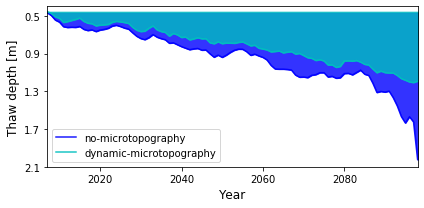

In [377]:
# Thaw depth timeseries
fig, axs = plt.subplots(1,1, figsize=(6,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
#axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['c', 'b', 'b','grey']

for i1, i in enumerate([2,0]):
    s = SimLabels[i]
    d = 0*ATD_annual[s][0] - get_moving_average(ATD_annual[s], 5)
    axs.plot(T_annual[s]-0.5, d, color=Colors[i],alpha=0.9,label=Labels[i])
    axs.fill_between(T_annual[s]-0.5, y1=d, y2=d[0], color=Colors[i],alpha=0.8)
axs.set_ylabel('Thaw depth [m]',fontsize=12, fontweight='normal')
axs.set_xlabel('Year',fontsize=12, fontweight='normal')
axs.set_xticks(np.arange(2000,2100,20))
axs.set_xlim(2007,2098.)

axs.set_yticks(np.arange(-2.1, -0.4,0.4))
axs.set_yticklabels(np.round(np.arange(2.1,0.4,-0.4),2))
axs.set_ylim(-2.1, -0.4)


plt.tight_layout()
plt.legend(loc='lower left')
plt.savefig(outfile+'/TD_timeseries_A.pdf', bbox_inches='tight', dpi=500)

S1 [5.080048599999699, 5.080048599999699]
S3 [2.954707377393423, 2.954707377393423]


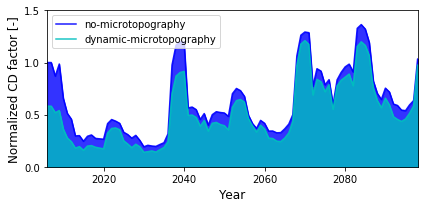

In [396]:
# Thaw depth timeseries
fig, axs = plt.subplots(1,1, figsize=(6,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
#axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['c', 'b', 'b','grey']

for i1, i in enumerate([2,0]):
    s = SimLabels[i]
    d = get_moving_average(CDR_annual[s], 5)
    print (s, d[:2])
    #d = [l/1.53 for l in d]
    d = [l/5.08 for l in d]
    axs.plot(T_annual[s]-0.5, d, color=Colors[i],alpha=0.9,label=Labels[i])
    axs.fill_between(T_annual[s]-0.5, y1=d, y2=0*d[0], color=Colors[i],alpha=0.8)
axs.set_ylabel('Normalized CD factor [-]',fontsize=12, fontweight='normal')
axs.set_xlabel('Year',fontsize=12, fontweight='normal')
axs.set_xticks(np.arange(2000,2100,20))
axs.set_xlim(2006,2098)

axs.set_yticks(np.arange(0, 1.501,0.5))
#axs.set_yticklabels(np.round(np.arange(0,1.4,-0.4),2))
axs.set_ylim(0, 1.5)


plt.tight_layout()
plt.legend(loc='upper left')
#plt.savefig(outfile+'/CDR_timeseries_A.pdf', bbox_inches='tight', dpi=500)

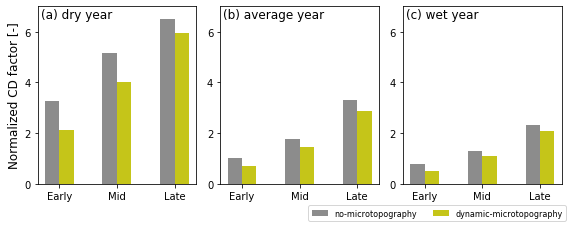

In [399]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['y', 'g', 'grey','grey']

# Discharge
for k in range(3):
    for i1, i in enumerate([2,0]):
        s = SimLabels[i]
        d = []
        for k1 in Years[k]:
            sm = np.mean(CDR_annual[s][k1])
            d.append(sm)
        #print (d)
        d = [d1/1.5174 for d1 in d] # normalized by average simplistic year
        #d = [d1/1.0840 for d1 in d] # normalized by average realistic year
        
        xx = x - 0.125 + i1*0.25
        axs[k].bar(xx, height=d, width=0.25,color=Colors[i],alpha=0.9,label=Labels[i])

    #axs[0].set_ylabel('Carbon decomposition factor [-]',fontsize=12, fontweight='normal')
    axs[0].set_ylabel('Normalized CD factor [-]',fontsize=12, fontweight='normal')
    #axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x)
    axs[k].set_xticklabels(Years_o)

    #axs[k].set_yticks(np.arange(0.0,15.001,1.0))
    #axs[k].set_ylim(0.0,15.0)
"""
axs[0].set_yticks(np.arange(0.0,4.001,2.0))
axs[0].set_ylim(0.0,4.0)
axs[1].set_yticks(np.arange(0.0,10.001,5.0))
axs[1].set_ylim(0.0,10.0)
axs[2].set_yticks(np.arange(0.0,6.001,3.0))
axs[2].set_ylim(0.0,6.0)
"""
for i in range(3):
    axs[i].set_yticks(np.arange(0.0,7.01,2.0))
    axs[i].set_ylim(0.0,7.0)


plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=2, bbox_to_anchor=(0.95,-0.2, .1, .1))
#plt.tight_layout()
A = ['(a) dry year','(b) average year', '(c) wet year']
#loc = [[-0.32,i] for i in [3.7,5.2,5.52,1.33]]

loc = [[-0.32,6.55] for i in [3.9,3.9,3.9,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)

plt.savefig(outfile+'/CD_wet_dry_avg_normalized.pdf', bbox_inches='tight', dpi=500)

#Q10 is a unitless quantity, as it is the factor by which a rate changes, 
#and is a useful way to express the temperature dependence of a process.

# Dry Year

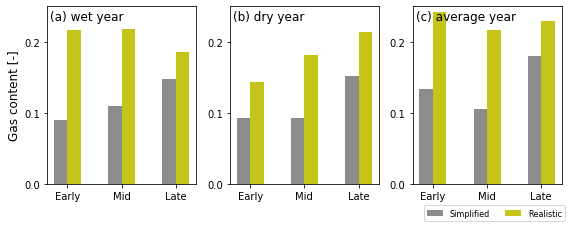

In [125]:
fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

x = np.arange(0,3,1)
Colors = ['y', 'g', 'grey','grey']

# Discharge
for k in range(3):
    for i1, i in enumerate([2,0]):
        s = SimLabels[i]
        d = []
        for k1 in Years[k]:
            #sm = np.mean(SFrac_annual[s][k1])
            #sm = np.mean(VWC_annual[s][k1])
            sm = np.mean(GC_annual[s][k1])
            
            d.append(sm)
        xx = x - 0.125 + i1*0.25
        axs[k].bar(xx, height=d, width=0.25,color=Colors[i],alpha=0.9,label=Labels[i])

    #axs[0].set_ylabel('Saturated fraction [-]',fontsize=12, fontweight='normal')
    axs[0].set_ylabel('Gas content [-]',fontsize=12, fontweight='normal')
    #axs[k].set_xlabel('Year',fontsize=12, fontweight='normal')
    axs[k].set_xticks(x)
    axs[k].set_xticklabels(Years_o)

    #axs[k].set_yticks(np.arange(0.3,0.701,0.1))
    #axs[k].set_ylim(0.3,0.7)
    axs[k].set_yticks(np.arange(0.0,0.2501,0.1))
    axs[k].set_ylim(0.0,0.25)

plt.tight_layout()
axs[2].legend(loc='upper right', fontsize=8, ncol=2, bbox_to_anchor=(0.95,-0.2, .1, .1))

A = ['(a) wet year', '(b) dry year','(c) average year']
#loc = [[-0.32,0.67] for i in [-0.25,137,0.77,1.33]]
loc = [[-0.32,0.23] for i in [-0.25,137,0.77,1.33]]
for i in range(3):
    axs[i].text(loc[i][0],loc[i][1],'%s'%A[i],fontsize=12)

#plt.savefig(outfile+'/Satfrac_wet_dry_avg.pdf', bbox_inches='tight', dpi=500)
plt.savefig(outfile+'/gascontent_wet_dry_avg.pdf', bbox_inches='tight', dpi=500)

In [117]:
x11 = (0.87*0.5 * 4)
x22 = (0.87*0.5 * 2)
d11 = 0.8
d22 = 0.4
print (x11/d11, x22/d22)

2.175 2.175


In [ ]:

# the key point what processes are important for water budget components, 
# sensitivity study of subsidence, models with more or less uniform subsidence across the watershed has no effect
# on hydrology, however, hetereogeneous subsidence has effect on runoff/ET ---> investigate?
# storage decreases in simulations with subsidence
# lets focus on the processes details instead of conclusions about the future.


In [ ]:
Including run-on in our simulations improve our understanding of total carbon budget. the evaporation will be under estimated
if we ignore run-on
long-term trend
inter-annual dynamics
seasonal vairations/dynamics
fire consumes carbon, which decrease DOC in stream

In [ ]:
# 1) negligible differences in the discharge
# 2) significant differences in the evaporation, this implies base-case should stay relatively wetter,
#.   this will impact carbon decomposition rate
# 3) high NO3 and low N03, high DOC 

In [ ]:
2 meadian life time , 2.6hr give mean of 1hr median
alpha = 2.5 1/sec